# Assignment 1: From Dirty Data to Predictive Models

Federico Giorgi (fg2617)

Titanic Survival Dataset

## Dataset Description

**Data Dictionary**

| Variable  | Definition                          | Key                                  |
|-----------|-------------------------------------|--------------------------------------|
| survival  | Survival                            | 0 = No, 1 = Yes                      |
| pclass    | Ticket class                        | 1 = 1st, 2 = 2nd, 3 = 3rd            |
| sex       | Sex                                 |                                      |
| age       | Age in years                        |                                      |
| sibsp     | # of siblings / spouses aboard      |                                      |
| parch     | # of parents / children aboard      |                                      |
| ticket    | Ticket number                       |                                      |
| fare      | Passenger fare                      |                                      |
| cabin     | Cabin number                        |                                      |
| embarked  | Port of Embarkation                 | C = Cherbourg, Q = Queenstown, S = Southampton |


**Variable Notes**
pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Basics

In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, classification_report, make_scorer, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, KFold, learning_curve, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB


In [414]:
df_train0 = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

## 1 Exploratory data analysis and visualization

In [415]:
df_train0["Survived_label"] = df_train0["Survived"].map({0: "Did not survive", 1: "Survived"})
df_train0.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_label
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Did not survive
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Did not survive


### 1.1 Univariate Data Analysis

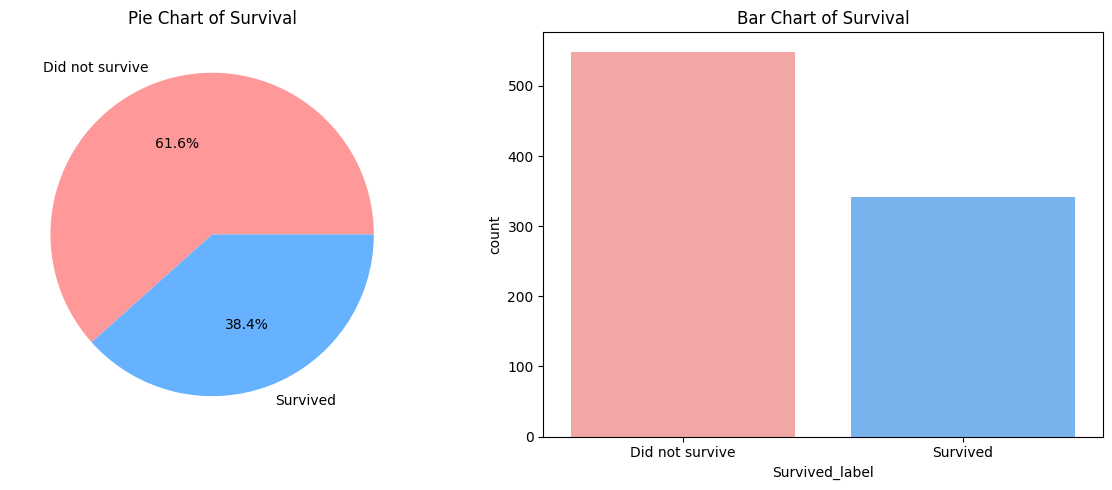

In [416]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
df_train0["Survived"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Did not survive", "Survived"],
    colors=["#FF9999", "#66B2FF"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Survival")

# Bar chart
sns.countplot(x="Survived_label", data=df_train0, palette=["#FF9999", "#66B2FF"], ax=axes[1],  hue="Survived_label", legend=False)
axes[1].set_title("Bar Chart of Survival")

plt.tight_layout()
plt.show()

The survival variable shows a clear imbalance, with about 62% of passengers not surviving and 38% surviving. This imbalance means that accuracy alone would not be a reliable performance measure, as a trivial model predicting non-survival for all cases would already achieve a high score.

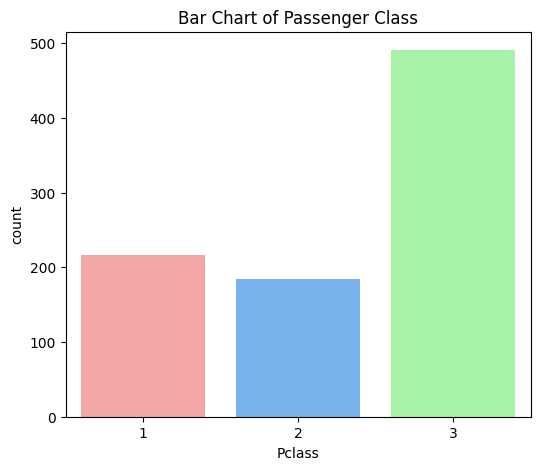

In [417]:
plt.figure(figsize=(6, 5))
sns.countplot(x="Pclass", data=df_train0, palette=["#FF9999", "#66B2FF", "#99FF99"],  hue="Pclass", legend=False)
plt.title("Bar Chart of Passenger Class")
plt.show()

Passenger class is unevenly distributed, with the majority of passengers in third class, fewer in first class, and the least in second class. This indicates that the dataset is skewed toward lower-class passengers, which is important for understanding how representative the sample is and sets the stage for later analysis of survival differences across classes.

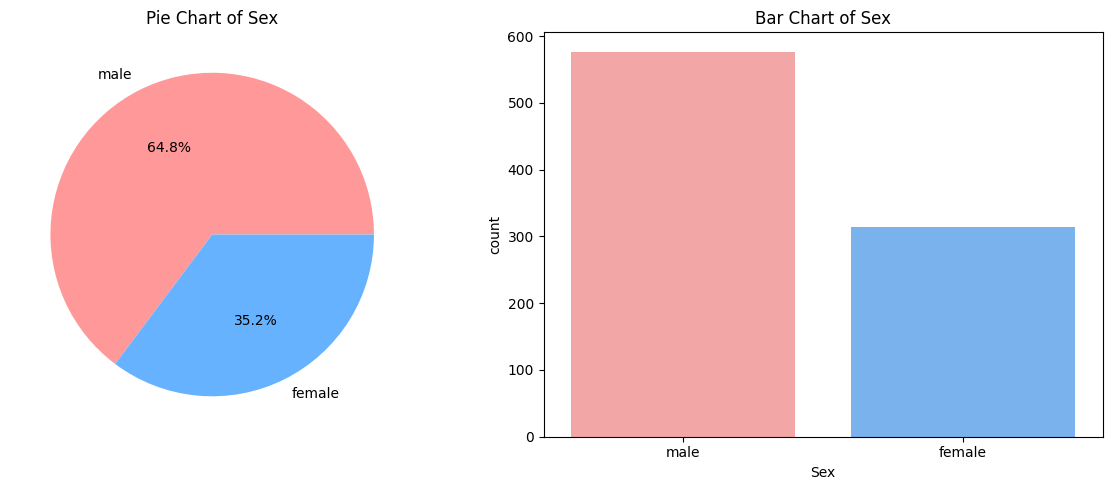

In [418]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train0["Sex"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=["#FF9999", "#66B2FF"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Sex")

sns.countplot(x="Sex", data=df_train0, palette=["#FF9999", "#66B2FF"], ax=axes[1],  hue="Sex", legend=False)
axes[1].set_title("Bar Chart of Sex")

plt.tight_layout()
plt.show()

The sex variable shows a clear imbalance, with about 65% of passengers being male and 35% female. This indicates that men were nearly twice as represented as women in the dataset, a demographic skew that is important to consider when analyzing outcomes. At this stage it only describes population composition, but it will later be relevant for assessing whether sex had an influence on survival.


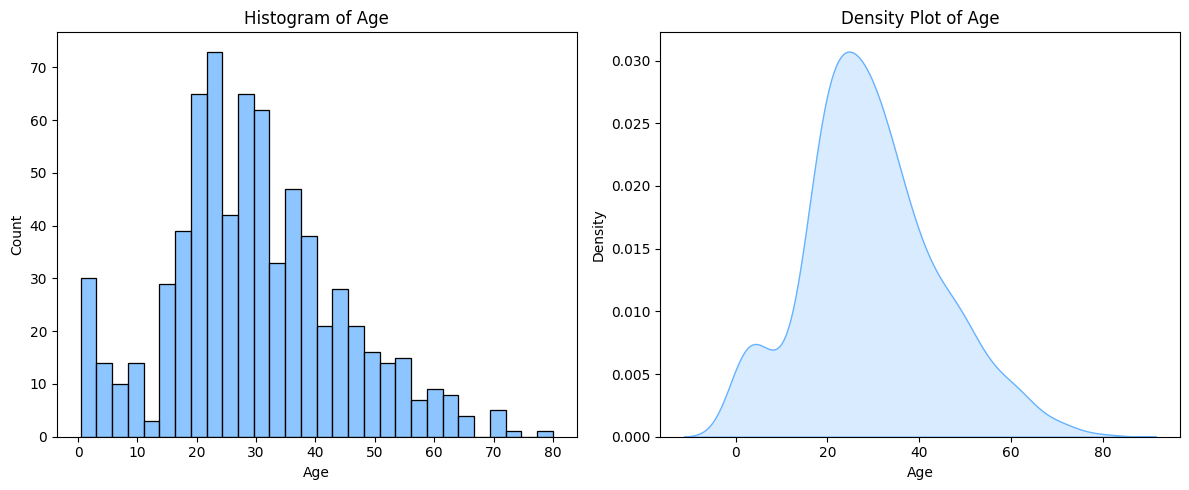

In [419]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train0["Age"].dropna(), bins=30, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of Age")

sns.kdeplot(df_train0["Age"].dropna(), fill=True, color="#66B2FF", ax=axes[1])
axes[1].set_title("Density Plot of Age")

plt.tight_layout()
plt.show()

The age distribution is right-skewed, with most passengers concentrated between 20 and 40 years old and fewer observations at higher ages. There is a small peak for very young children and a long tail extending into older ages above 60. This indicates that the dataset is dominated by young to middle-aged adults, while elderly passengers are underrepresented. Such skewness could impact modeling, as age may need transformation or binning to better capture differences across groups.

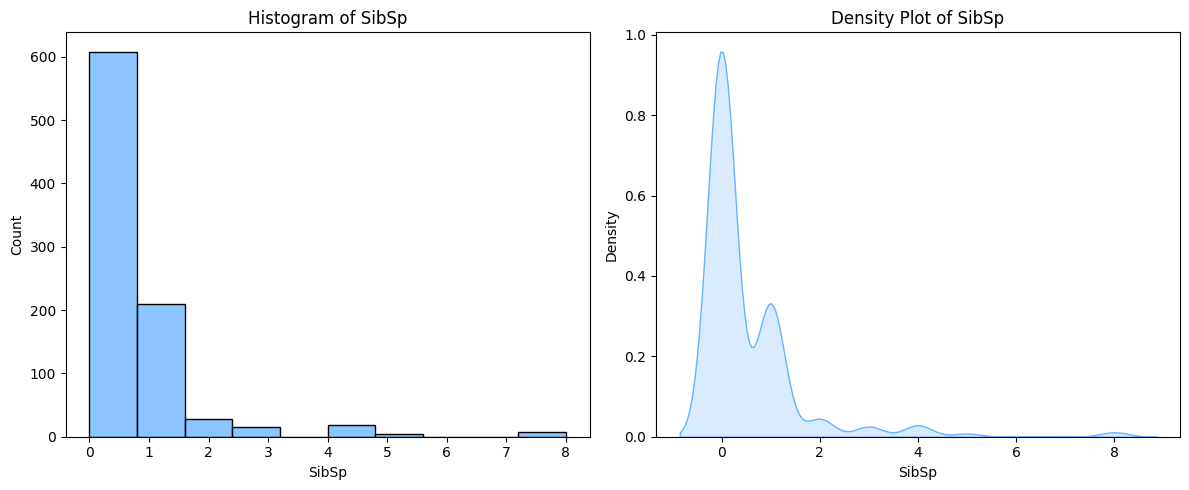

In [420]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train0["SibSp"], bins=10, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of SibSp")

sns.kdeplot(df_train0["SibSp"], fill=True, color="#66B2FF", ax=axes[1])
axes[1].set_title("Density Plot of SibSp")

plt.tight_layout()
plt.show()

Most passengers had no siblings or spouses with them, and a smaller but visible group had one. Higher counts above two are rare and appear as outliers. This heavy concentration at the lower end suggests that the majority of passengers were traveling alone or with just one close family member, while large family groups were exceptional. Such skewness means SibSp may provide predictive value mainly through distinguishing between individuals traveling alone and those with at least one companion.

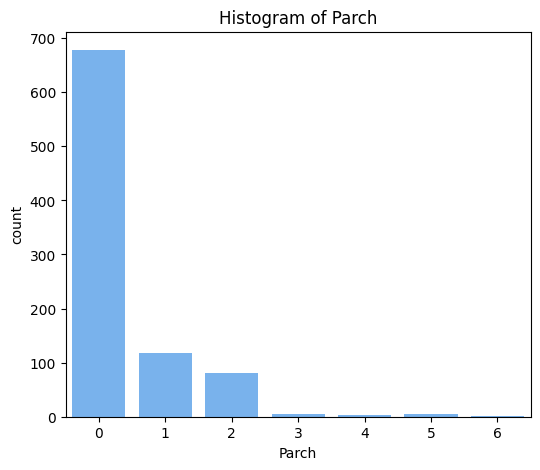

In [421]:
plt.figure(figsize=(6, 5))
sns.countplot(x="Parch", data=df_train0, color="#66B2FF")
plt.title("Histogram of Parch")
plt.show()

The majority of passengers had no immediate family with them, while smaller groups had one or two, and larger values above three are very rare. This indicates that most travelers were not accompanied by close family, with only a minority traveling in family units. The concentration at zero makes it similar in shape to SibSp, and its predictive contribution may come from distinguishing solo travelers from those with at least one parent or child on board.

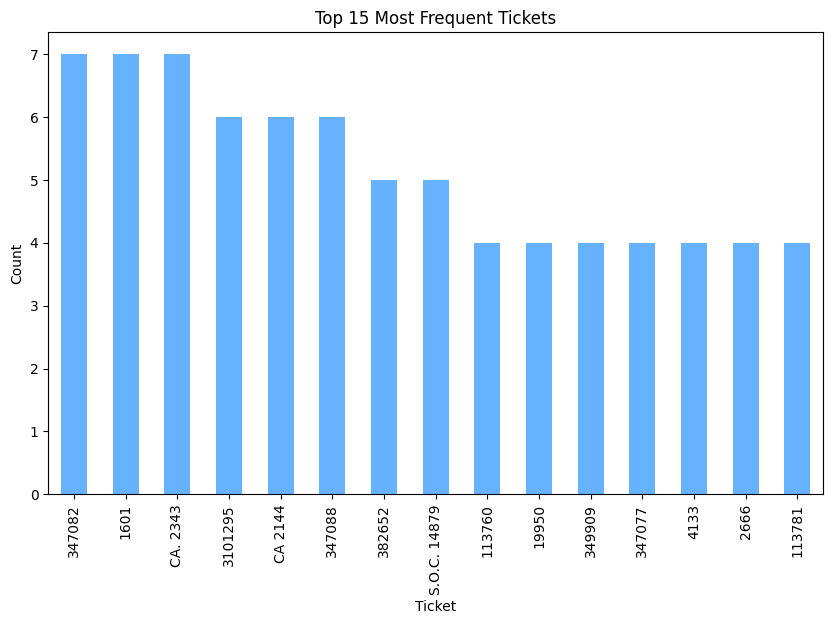

In [422]:
plt.figure(figsize=(10, 6))
df_train0["Ticket"].value_counts().head(15).plot(kind="bar", color="#66B2FF")
plt.title("Top 15 Most Frequent Tickets")
plt.xlabel("Ticket")
plt.ylabel("Count")
plt.show()


The ticket variable obviously does not provide meaningful information for modeling. Its distribution is highly fragmented, with most values unique or appearing only a handful of times, making it effectively an identifier rather than a useful predictive feature.

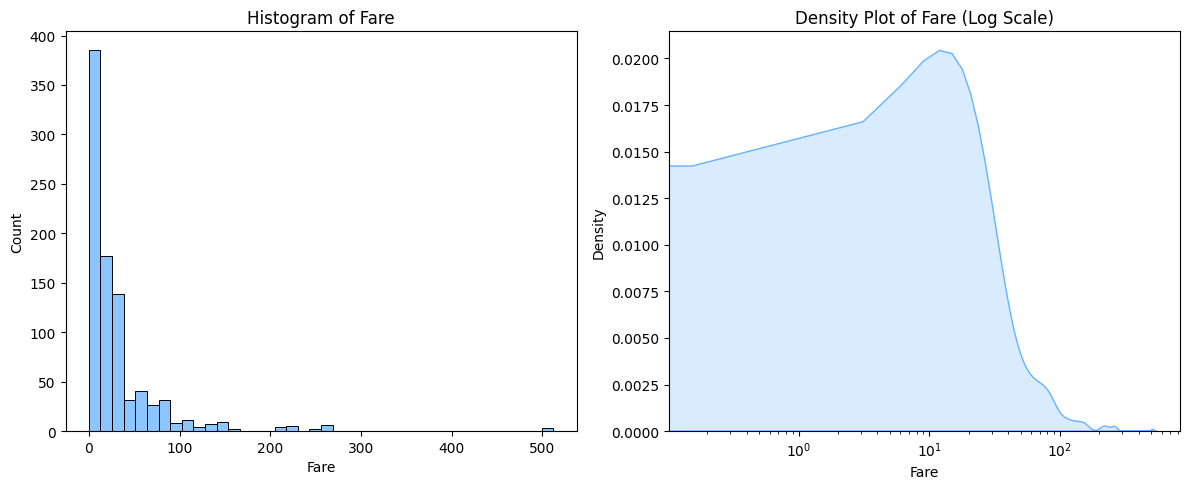

In [423]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train0["Fare"], bins=40, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of Fare")

sns.kdeplot(df_train0["Fare"], fill=True, color="#66B2FF", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_title("Density Plot of Fare (Log Scale)")

plt.tight_layout()
plt.show()

The fare variable is highly right-skewed, with most passengers paying relatively low amounts and a few outliers with very high fares. Applying a log transformation makes the distribution more balanced and easier to model. The large spread in values suggests fare could be informative for distinguishing between passenger groups, potentially correlating with socioeconomic status or class.

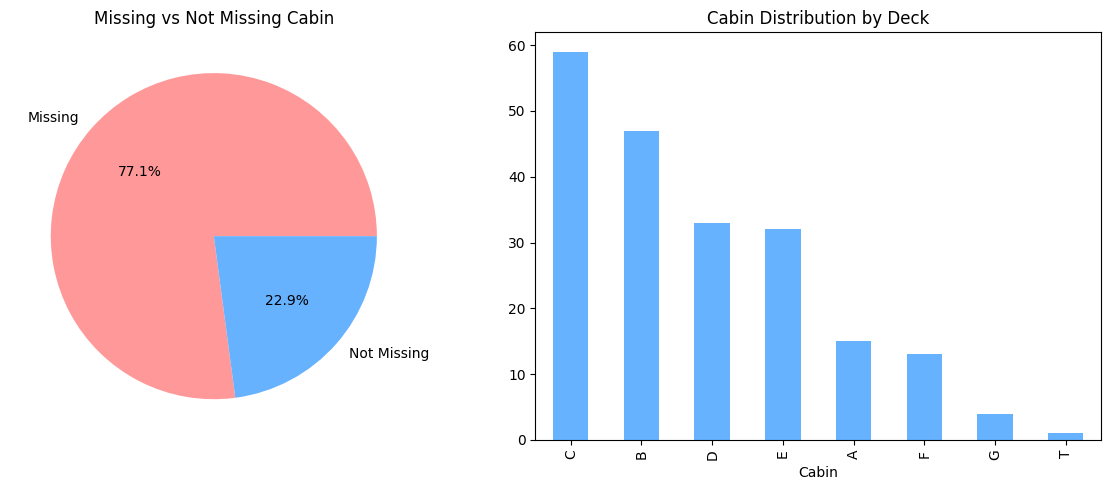

In [424]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train0["Cabin"].isnull().value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Missing", "Not Missing"],
    colors=["#FF9999", "#66B2FF"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Missing vs Not Missing Cabin")

df_train0["Cabin"].dropna().str[0].value_counts().plot(kind="bar", color="#66B2FF", ax=axes[1])
axes[1].set_title("Cabin Distribution by Deck")

plt.tight_layout()
plt.show()

The cabin variable has a very high proportion of missing values, with over 77% of entries unavailable. Among the non-missing cases, the distribution across decks is uneven, with decks C and B most represented while others have very few observations. Because of the extensive missingness and the sparsity of certain categories, the variable is of limited direct use in modeling unless imputation or grouping strategies are applied.

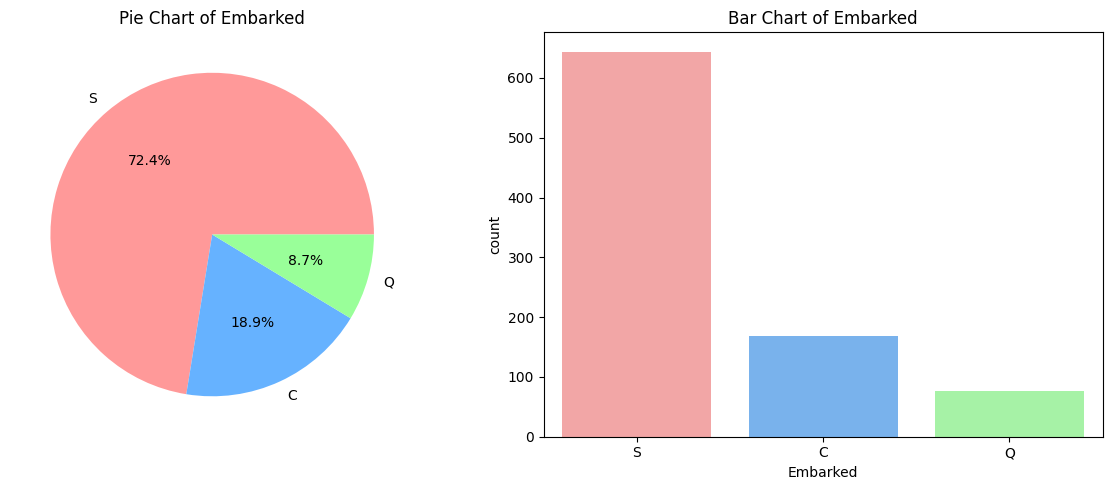

In [425]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train0["Embarked"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=["#FF9999", "#66B2FF", "#99FF99"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Embarked")

sns.countplot(x="Embarked", data=df_train0, palette=["#FF9999", "#66B2FF", "#99FF99"], ax=axes[1],  hue="Embarked", legend=False)
axes[1].set_title("Bar Chart of Embarked")

plt.tight_layout()
plt.show()


The embarked variable is dominated by port S, which accounts for more than 70% of passengers, while port C represents about 19% and port Q less than 10%. This strong imbalance shows that most passengers boarded at a single port, with the others much less represented. Although categorical, the skew in distribution may still provide useful information when combined with other features, but its predictive contribution alone is likely limited.

### 1.2 Multivariate Data Analysis

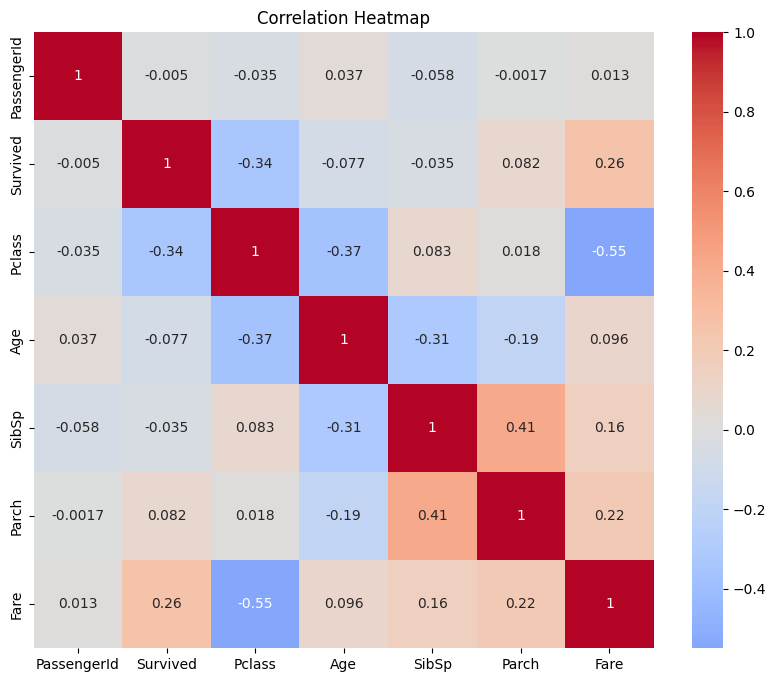

In [426]:
plt.figure(figsize=(10, 8))
corr = df_train0.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

The correlation heatmap shows that survival has moderate negative correlation with passenger class and positive correlation with fare, suggesting socioeconomic status is linked to outcomes. SibSp and Parch are positively correlated with each other, reflecting their shared role in representing family size. Age shows weak correlations overall, while passenger ID behaves as expected like an identifier with no meaningful relation. The strongest relationship in the dataset is between class and fare, which are naturally tied, and this redundancy should be considered in feature selection

#### 1.2.1 Analysis of the dependence of "Survived" on other variables.

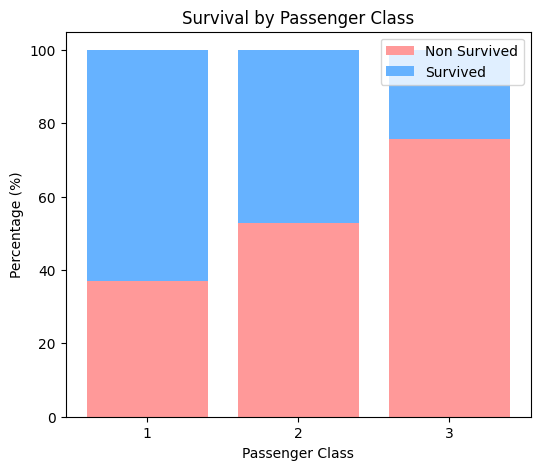

In [427]:
percent_df = (
    df_train0.groupby("Pclass")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Pclass", columns="Survived", values="Percentage")
plt.figure(figsize=(6,5))

plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Passenger Class")
plt.ylabel("Percentage (%)")
plt.xlabel("Passenger Class")
plt.legend()
plt.show()

Survival rates vary strongly by passenger class. First-class passengers had the highest survival probability, with more than 60% surviving, while second-class survival was close to 50%. In contrast, third-class passengers had a much lower survival rate, with over 70% not surviving. This confirms that class was an important factor influencing outcomes and suggests it will be a key predictive feature in modeling survival.


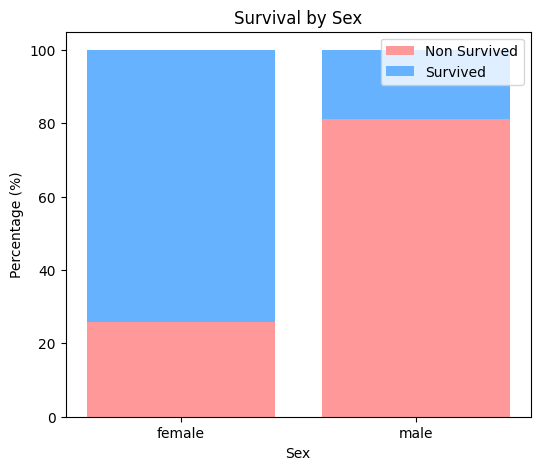

In [428]:
percent_df = (
    df_train0.groupby("Sex")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Sex", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Sex")
plt.ylabel("Percentage (%)")
plt.xlabel("Sex")
plt.legend()
plt.show()

The plot shows a stark difference in survival by sex. Around three quarters of women survived compared to only about one fifth of men. This highlights sex as a highly discriminative feature, with a much higher probability of survival for females. The imbalance strongly suggests that gender roles and evacuation priorities influenced outcomes, making this one of the most predictive variables in the dataset.

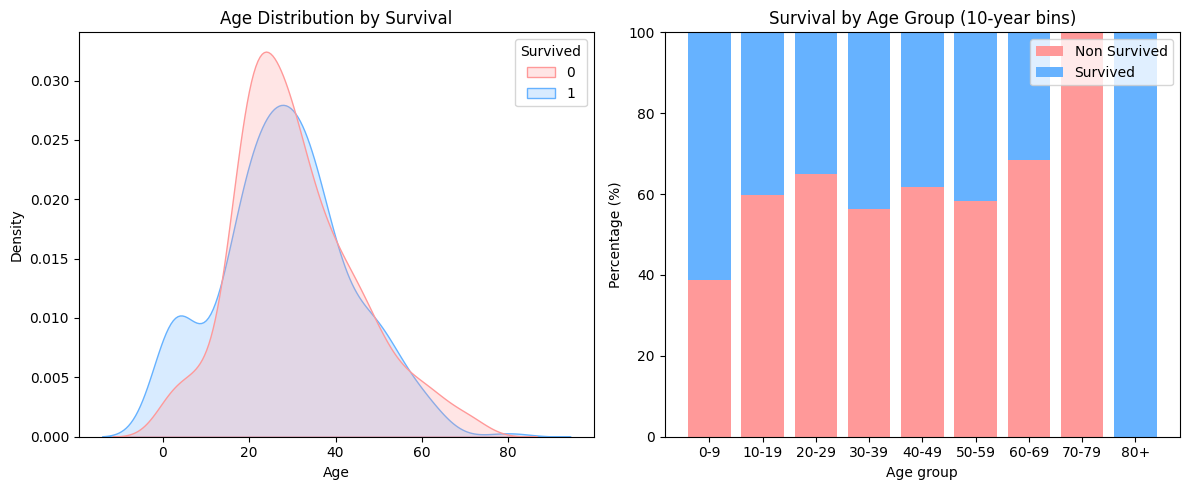

In [429]:
bins = list(range(0, 81, 10)) + [np.inf]
labels = [f"{i}-{i+9}" for i in range(0, 80, 10)] + ["80+"]

df_train0["AgeBin"] = pd.cut(df_train0["Age"], bins=bins, labels=labels, right=False)

percent_df = (
    df_train0.groupby("AgeBin", observed=False)["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="AgeBin", columns="Survived", values="Percentage")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(
    x="Age", hue="Survived", data=df_train0, fill=True, common_norm=False,
    palette=["#FF9999", "#66B2FF"], ax=axes[0]
)
axes[0].set_title("Age Distribution by Survival")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Density")

axes[1].bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
axes[1].bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")
axes[1].set_title("Survival by Age Group (10-year bins)")
axes[1].set_ylabel("Percentage (%)")
axes[1].set_xlabel("Age group")
axes[1].legend()

plt.tight_layout()
plt.show()


The left plot shows the age distribution by survival, where most passengers in both groups fall between 20 and 40 years, with children standing out as more likely to survive. The right plot with age bins confirms that survival rates were highest for those under 10, more balanced but lower for adults, and particularly low for older passengers. This indicates that age is an informative predictor, especially in distinguishing children and elderly from the main adult group.

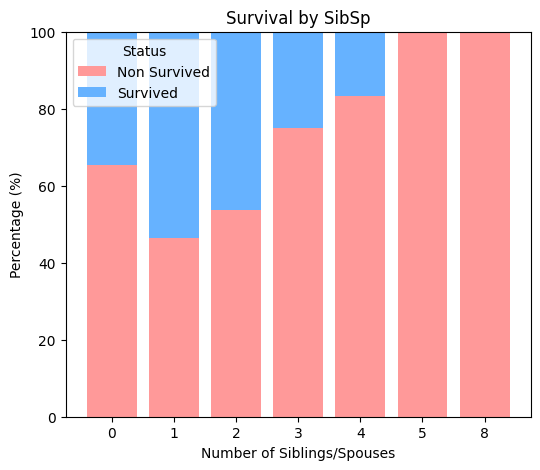

In [430]:
percent_df = (
    df_train0.groupby("SibSp")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="SibSp", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by SibSp")
plt.ylabel("Percentage (%)")
plt.xlabel("Number of Siblings/Spouses")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

The plot shows that survival chances varied with the number of siblings or spouses aboard. Passengers traveling with one or two companions had relatively higher survival rates, while those traveling alone or in very large groups had lower survival. In particular, survival probability drops sharply for counts above three, where almost all passengers did not survive. This suggests that moderate family presence could be beneficial, but larger groups were strongly disadvantaged.

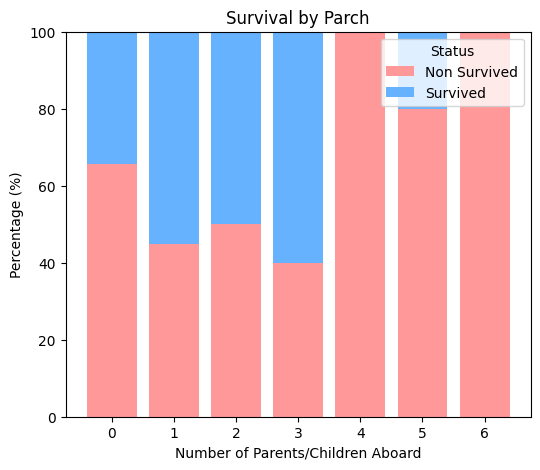

In [431]:
percent_df = (
    df_train0.groupby("Parch")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Parch", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Parch")
plt.ylabel("Percentage (%)")
plt.xlabel("Number of Parents/Children Aboard")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

The plot indicates that survival was higher for passengers with one to three parents or children aboard compared to those traveling alone or with larger family groups. Individuals without family had a lower survival rate, while very large families (four or more) show almost no survival. This suggests that having a small family presence may have increased the chances of survival, but being in large groups was a disadvantage.


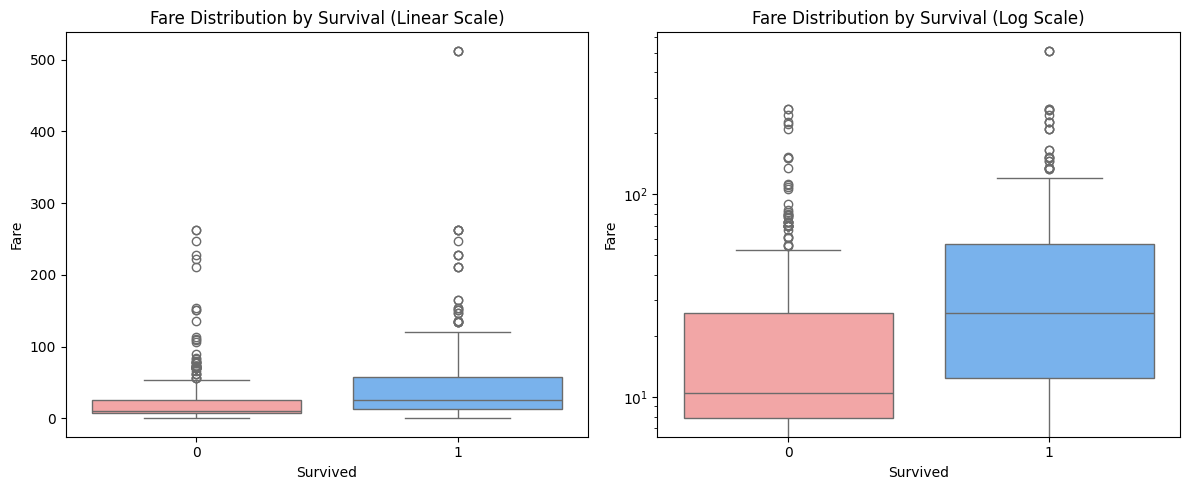

In [432]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(
    x="Survived", y="Fare", data=df_train0,
    palette=["#FF9999", "#66B2FF"], hue="Survived", legend=False, ax=axes[0]
)
axes[0].set_title("Fare Distribution by Survival (Linear Scale)")
axes[0].set_ylabel("Fare")

sns.boxplot(
    x="Survived", y="Fare", data=df_train0,
    palette=["#FF9999", "#66B2FF"], hue="Survived", legend=False, ax=axes[1]
)
axes[1].set_yscale("log")
axes[1].set_title("Fare Distribution by Survival (Log Scale)")
axes[1].set_ylabel("Fare")

plt.tight_layout()
plt.show()


The side-by-side boxplots confirm that fare is an important discriminative feature. On the linear scale the differences are masked by a few extreme outliers, but the log scale makes the pattern clearer: survivors generally paid higher fares, with both the median and the interquartile range shifted upward compared to non-survivors. This supports the interpretation that fare, as a proxy for passenger class or socioeconomic status, strongly influenced survival probability.

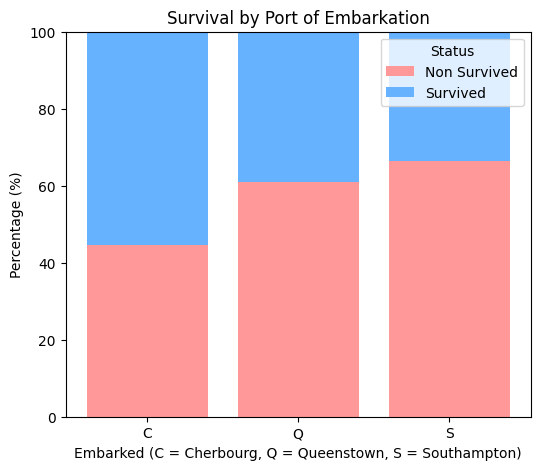

In [433]:
percent_df = (
    df_train0.groupby("Embarked")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Embarked", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Port of Embarkation")
plt.ylabel("Percentage (%)")
plt.xlabel("Embarked (C = Cherbourg, Q = Queenstown, S = Southampton)")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

The chart shows clear differences in survival depending on the port of embarkation. Passengers from Cherbourg had the highest survival rate, with more than half surviving. Those from Queenstown had a lower survival probability, while passengers from Southampton had the lowest, with about two-thirds not surviving. This suggests that port of embarkation carries useful information, likely reflecting differences in passenger composition such as class distribution or socioeconomic status.

#### 1.2.2 Larger scope analysis

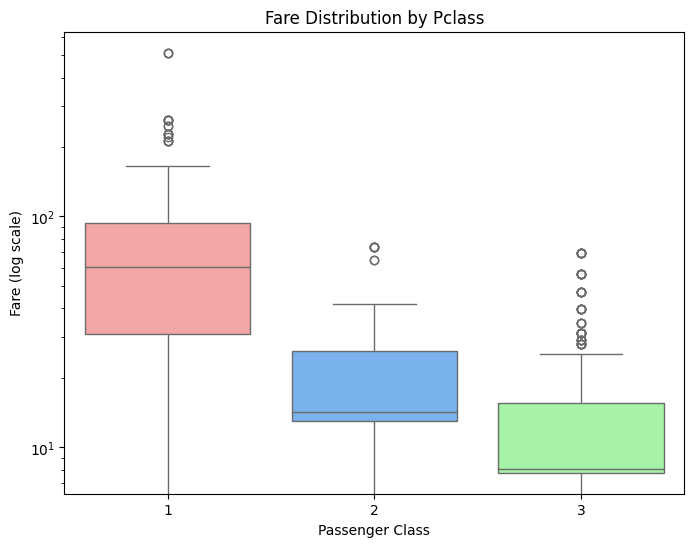

In [434]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x="Pclass",
    y="Fare",
    data=df_train0,
    palette=["#FF9999", "#66B2FF", "#99FF99"],
    hue="Pclass", legend=False
)
plt.yscale("log")
plt.title("Fare Distribution by Pclass")
plt.ylabel("Fare (log scale)")
plt.xlabel("Passenger Class")
plt.show()


The boxplot shows a clear separation of fare distributions across passenger classes. First-class passengers paid the highest fares with a wide spread and many high-value outliers, second-class fares were lower and more concentrated, while third-class passengers had the lowest fares overall. The log scale makes the differences more visible and confirms a strong association between class and fare, reflecting their redundancy as socioeconomic indicators.

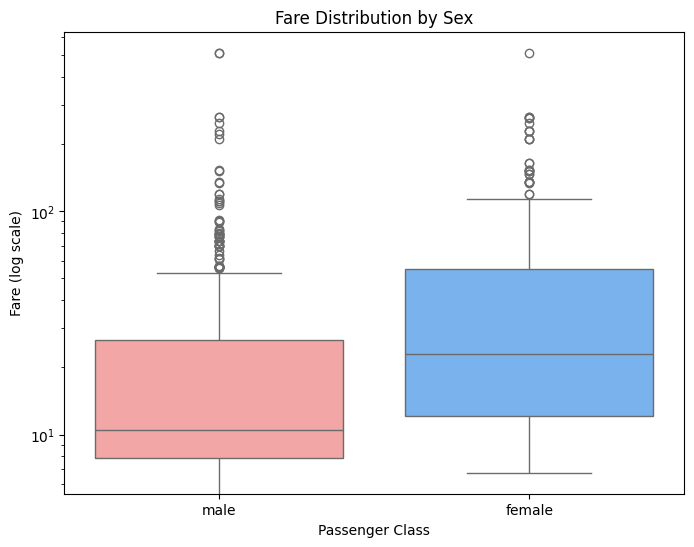

In [435]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x="Sex",
    y="Fare",
    data=df_train0,
    palette=["#FF9999", "#66B2FF"],
    hue="Sex", legend=False
)
plt.yscale("log")
plt.title("Fare Distribution by Sex")
plt.ylabel("Fare (log scale)")
plt.xlabel("Passenger Class")
plt.show()

Females generally paid higher fares than males. The median fare for women is clearly above that of men, and their distribution is more spread out across higher values. Men are concentrated at lower fares, with relatively few paying at the top end. Since fare is strongly linked to passenger class and socioeconomic status, this suggests that women in the dataset were more represented in higher classes, which in turn is associated with better survival chances.

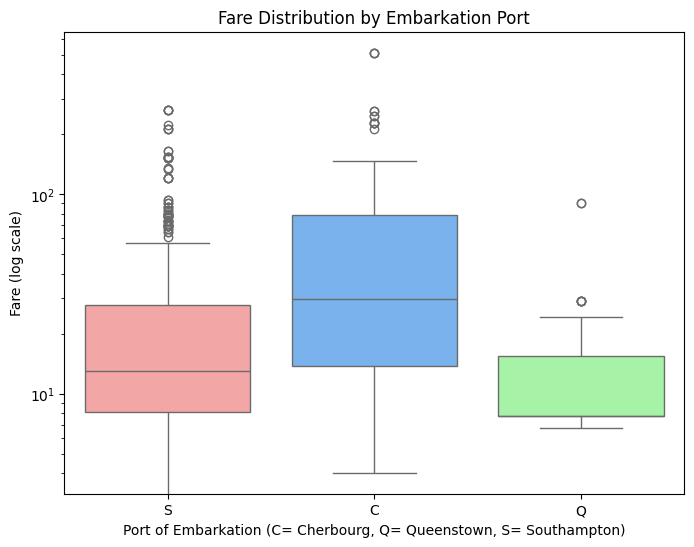

In [436]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x="Embarked",
    y="Fare",
    data=df_train0,
    palette=["#FF9999", "#66B2FF", "#99FF99"],
    hue="Embarked", legend=False
)
plt.yscale("log")
plt.title("Fare Distribution by Embarkation Port")
plt.ylabel("Fare (log scale)")
plt.xlabel("Port of Embarkation (C= Cherbourg, Q= Queenstown, S= Southampton)")
plt.show()


The boxplot shows that fares varied notably by port of embarkation. Passengers boarding at Cherbourg generally paid the highest fares with a wide spread, Southampton passengers paid lower fares with many concentrated at the bottom range, and Queenstown passengers paid the lowest fares overall. This pattern suggests that the port of embarkation is indirectly capturing differences in passenger composition, such as class and socioeconomic background.

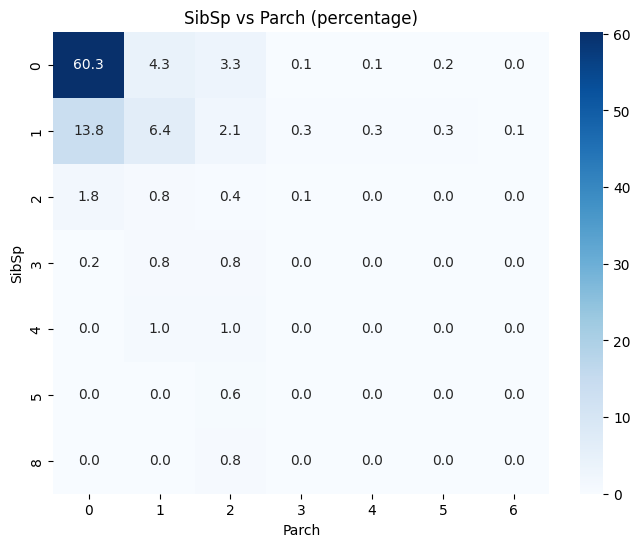

In [437]:
cross_tab = pd.crosstab(df_train0["SibSp"], df_train0["Parch"])
cross_tab_pct = cross_tab.div(cross_tab.sum().sum()).mul(100)

plt.figure(figsize=(8,6))
sns.heatmap(cross_tab_pct, cmap="Blues", annot=True, fmt=".1f")
plt.title("SibSp vs Parch (percentage)")
plt.xlabel("Parch")
plt.ylabel("SibSp")
plt.show()


The majority of passengers, over 60%, had no siblings/spouses and no parents/children aboard. About 14% had one sibling/spouse but no parents/children, and smaller groups appear in low-frequency combinations such as one or two relatives of each type. Larger families are rare and represent less than 1% each.

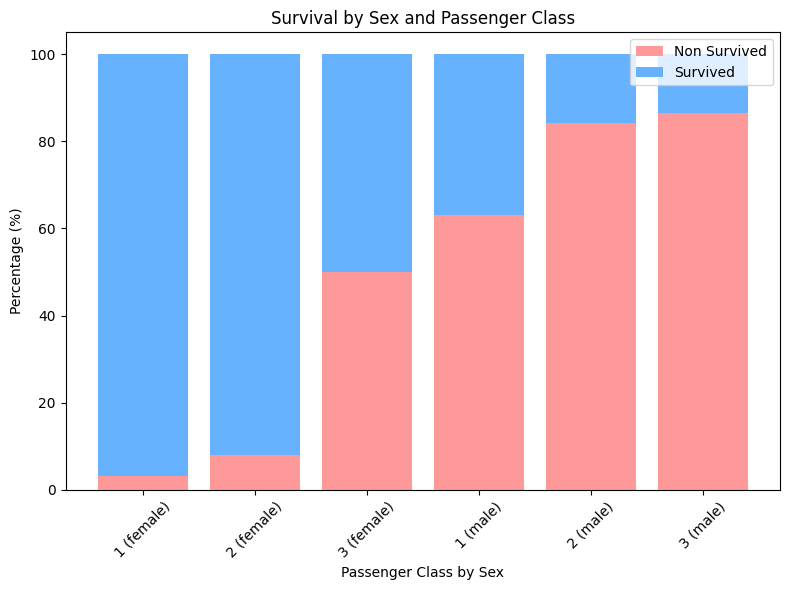

In [438]:
percent_df = (
    df_train0.groupby(["Sex", "Pclass"])["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot_table(
    index=["Sex", "Pclass"], columns="Survived", values="Percentage"
)

pivot_df = pivot_df.reset_index()

plt.figure(figsize=(8,6))

for sex in pivot_df["Sex"].unique():
    subset = pivot_df[pivot_df["Sex"] == sex]
    plt.bar(
        subset["Pclass"].astype(str) + " (" + sex + ")",
        subset[0],
        label="Non Survived" if sex == "male" else "",
        color="#FF9999"
    )
    plt.bar(
        subset["Pclass"].astype(str) + " (" + sex + ")",
        subset[1],
        bottom=subset[0],
        label="Survived" if sex == "male" else "",
        color="#66B2FF"
    )

plt.title("Survival by Sex and Passenger Class")
plt.ylabel("Percentage (%)")
plt.xlabel("Passenger Class by Sex")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Females in first and second class had extremely high survival rates, with survival exceeding 90%. Third-class females survived at lower rates, but still much higher than men. For males, the trend is the opposite: survival was poor across all classes, with first-class men doing somewhat better than second- and third-class, but still with the majority not surviving.

## 2 Data Cleaning

### 2.1 Missing Values

In [439]:
total = df_train0.isnull().sum().sort_values(ascending=False)
percent = (df_train0.isnull().sum() / len(df_train0)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
Cabin,687,0.771044
Age,177,0.198653
AgeBin,177,0.198653
Embarked,2,0.002245
Survived,0,0.000000
PassengerId,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000
SibSp,0,0.000000


In [440]:
df_train0 = df_train0.drop(columns=["Cabin"])

Dropping the Cabin variable is reasonable because more than 77% of its values are missing. With such a high level of missingness, any imputation strategy would introduce a large amount of noise and uncertainty. While cabin information could in principle contain predictive value (e.g., deck location), the incompleteness makes it unreliable. Removing the column ensures the model does not learn spurious patterns from heavily imputed data.

In [441]:
df_train0["Age"] = df_train0.groupby(["Pclass", "Sex"])["Age"].transform(
    lambda x: x.fillna(x.median())
)
df_train0["AgeBin"] = pd.cut(df_train0["Age"], bins=bins, labels=labels, right=False)

For the Age variable, imputing with the overall median would ignore heterogeneity in the dataset. A more refined approach is to impute within subgroups defined by passenger class and sex, since these characteristics are likely correlated with age distributions. For example, first-class passengers tended to be older, and women might have different age profiles than men. Filling missing values with the median of each (Pclass, Sex) group leverages available structure in the data and produces more realistic estimates. By updating AgeBin after imputation, the categorical representation of age remains aligned with the cleaned data and is ready for use in subsequent visualizations and modeling.

In [442]:
mode_embarked = df_train0["Embarked"].mode()[0]
df_train0["Embarked"] = df_train0["Embarked"].fillna(mode_embarked)

The Embarked variable has very few missing values, only two cases. In this situation, imputing with the mode is the simplest and most consistent approach. Since the vast majority of passengers embarked from Southampton, filling the missing entries with the most frequent category preserves the integrity of the dataset without distorting distributions.

In [443]:
# Final check: ensure no missing values remain
total = df_train0.isnull().sum().sort_values(ascending=False)
percent = (df_train0.isnull().sum() / len(df_train0)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0




---


The same transformations are now applied to the test dataset.

In [444]:
# Check missing values in df_test
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum() / len(df_test)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Name,0,0.000000
Pclass,0,0.000000
PassengerId,0,0.000000
Sex,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Ticket,0,0.000000


In [445]:
# 1. Drop Cabin Column
df_test = df_test.drop(columns=["Cabin"])

# 2. Imputation of median Age + Age Bin
df_test["Age"] = df_test.groupby(["Pclass", "Sex"])["Age"].transform(
    lambda x: x.fillna(x.median())
)
df_test["AgeBin"] = pd.cut(df_test["Age"], bins=bins, labels=labels, right=False)

# 3. Imputation of mode Embraked
mode_embarked = df_test["Embarked"].mode()[0]
df_test["Embarked"] = df_test["Embarked"].fillna(mode_embarked)

# 4. Imputation of median Fare
df_test["Fare"] = df_test.groupby(["Pclass", "Sex"])["Fare"] .transform(
    lambda x: x.fillna(x.median()
    ))

# Final check missing values in df_test
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum() / len(df_test)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["# Total", "% Total"])

missing_data.head(10)

,# Total,% Total
PassengerId,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0
Embarked,0,0.0


## 3 Feature Engineering
In this step the dataset is enriched through a series of transformations designed to turn raw attributes into features more suitable for modeling.

In [446]:
# make a working copy
df_train = df_train0.copy()

### 3.1 Family Group

Family information is consolidated by combining the number of siblings/spouses and parents/children into a total family size, which is then categorized into groups such as Alone, Small, Medium, and Large to capture different survival dynamics linked to family composition.

In [447]:
# Family size
df_train["Family size"] = df_train0["SibSp"] + df_train0["Parch"]
cond = [
    df_train["Family size"] == 0,
    df_train["Family size"].between(1, 3),
    df_train["Family size"].between(4, 6),
    df_train["Family size"].between(7, 11)
]
choice = ["Alone", "Small", "Medium", "Large"]

df_train["Family group"] = np.select(cond, choice, default="Other")
df_train["Family group"] = pd.Categorical(
    df_train["Family group"],
    categories=["Alone", "Small", "Medium", "Large"],
    ordered=True,
)

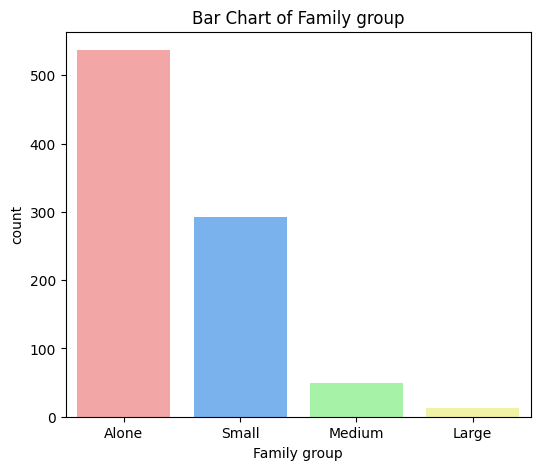

In [448]:
plt.figure(figsize=(6, 5))
sns.countplot(x="Family group", data=df_train, palette=["#FF9999", "#66B2FF", "#99FF99", "#FFFF99"],  hue="Family group", legend=False)
plt.title("Bar Chart of Family group")
plt.show()

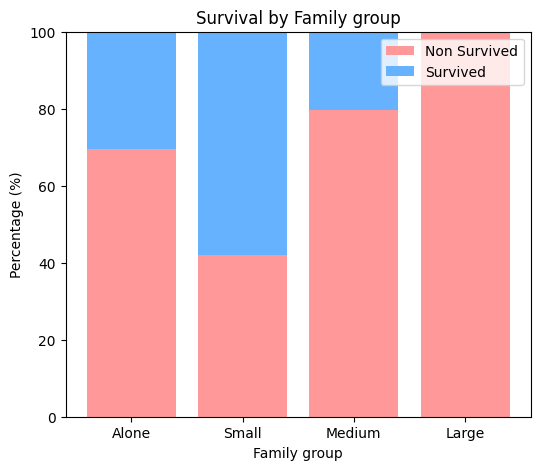

In [449]:
percent_df = (
    df_train.groupby("Family group", observed=False)["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Family group", columns="Survived", values="Percentage")
plt.figure(figsize=(6,5))

plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Family group")
plt.ylabel("Percentage (%)")
plt.xlabel("Family group")
plt.legend()
plt.show()

### 3.2 Title Status

Social status cues are extracted from the passenger’s name by isolating the title and retaining only the most frequent categories, while rare titles are grouped together.

In [450]:
# Title extraction
df_train["Title"] = df_train0["Name"].apply(
    lambda x: x.split(",")[1].split(".")[0].strip()
)
df_train["Title"] = df_train["Title"].apply(
    lambda t: t if t in ("Mr", "Mrs", "Miss", "Master") else "Other"
)

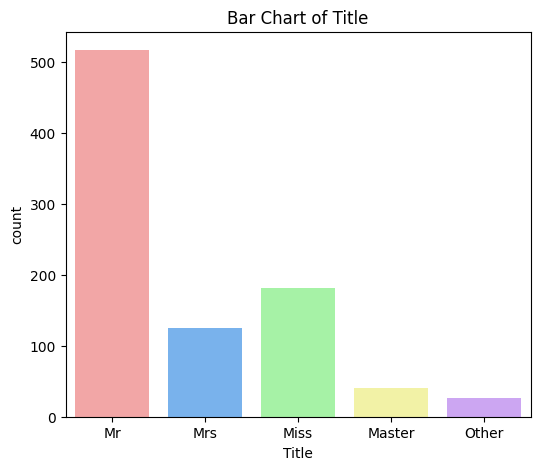

In [451]:
plt.figure(figsize=(6, 5))
sns.countplot(x="Title", data=df_train, palette=["#FF9999", "#66B2FF", "#99FF99", "#FFFF99", "#CC99FF"],  hue="Title", legend=False)
plt.title("Bar Chart of Title")
plt.show()

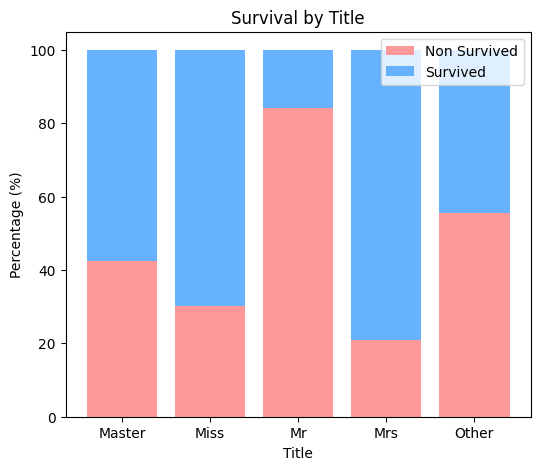

In [452]:
percent_df = (
    df_train.groupby("Title", observed=False)["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Title", columns="Survived", values="Percentage")
plt.figure(figsize=(6,5))

plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Title")
plt.ylabel("Percentage (%)")
plt.xlabel("Title")
plt.legend()
plt.show()

### 3.3 Log + Standardize Fare

Fare values, which are heavily skewed, are transformed with a logarithm and standardized so that they can be compared more directly to other features.

In [453]:
# Log + Standardize Fare
df_train["LogFare"] = np.log1p(df_train0["Fare"])
scaler = StandardScaler()
df_train["LogFare"] = scaler.fit_transform(df_train[["LogFare"]])

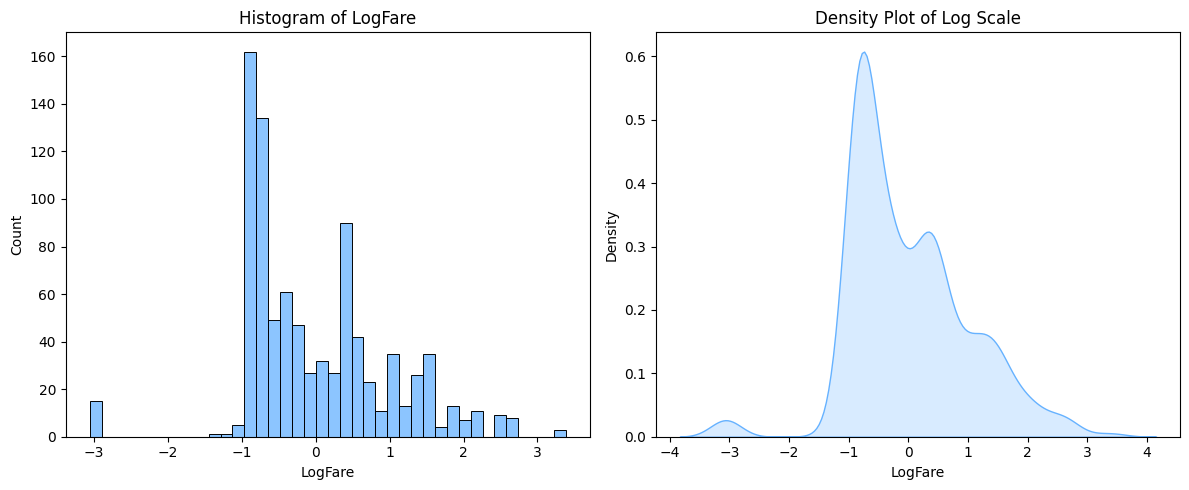

In [454]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train["LogFare"], bins=40, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of LogFare")

sns.kdeplot(df_train["LogFare"], fill=True, color="#66B2FF", ax=axes[1])
axes[1].set_title("Density Plot of Log Scale")

plt.tight_layout()
plt.show()

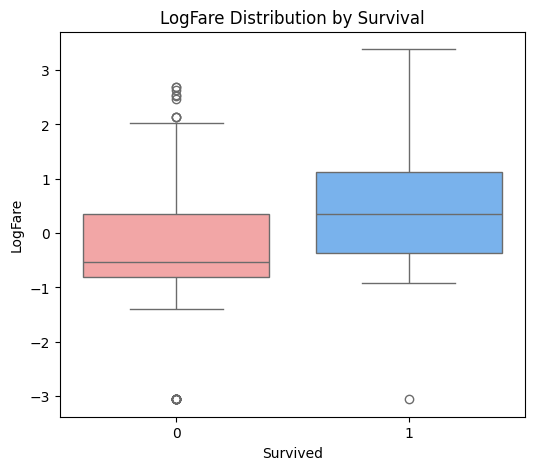

In [455]:
plt.figure(figsize=(6,5))

sns.boxplot(
    x="Survived", y="LogFare", data=df_train,
    palette=["#FF9999", "#66B2FF"], hue="Survived", legend=False
)
plt.title("LogFare Distribution by Survival")
plt.ylabel("LogFare")
plt.show()

### 3.4 Sex × Pclass interaction

In [456]:
# Sex × Pclass interaction
df_train["Sex_Pclass"] = df_train0["Sex"].astype(str) + "_" + df_train0["Pclass"].astype(str)

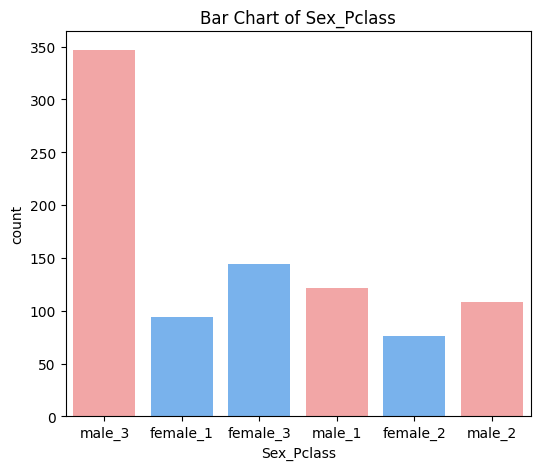

In [457]:
plt.figure(figsize=(6, 5))
sns.countplot(x="Sex_Pclass", data=df_train, palette=["#FF9999", "#66B2FF",],  hue="Sex", legend=False)
plt.title("Bar Chart of Sex_Pclass")
plt.show()

In [458]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived_label,AgeBin,Family size,Family group,Title,LogFare,Sex_Pclass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Did not survive,20-29,1,Small,Mr,-0.879741,male_3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Survived,30-39,1,Small,Mrs,1.361220,female_1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Survived,20-29,0,Alone,Miss,-0.798540,female_3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Survived,30-39,1,Small,Mrs,1.062038,female_1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Did not survive,30-39,0,Alone,Mr,-0.784179,male_3




---


The same transformations are now applied to the test dataset.

In [459]:
# Family size
df_test["Family size"] = df_test["SibSp"] + df_test["Parch"]
cond = [
    df_test["Family size"].isin([0, 1]),
    df_test["Family size"].isin([2, 3, 4]),
    df_test["Family size"].isin([5, 6]),
    df_test["Family size"].isin([7, 8, 11]),
]
choice = ["Alone", "Small", "Medium", "Large"]

df_test["Family group"] = np.select(cond, choice, default="Other")
df_test["Family group"] = pd.Categorical(
    df_test["Family group"],
    categories=["Alone", "Small", "Medium", "Large", "Other"],
    ordered=True,
)

# Title extraction
df_test["Title"] = df_test["Name"].apply(
    lambda x: x.split(",")[1].split(".")[0].strip()
)
df_test["Title"] = df_test["Title"].apply(
    lambda t: t if t in ("Mr", "Mrs", "Miss", "Master") else "Other"
)

# Log + Standardize Fare
df_test["LogFare"] = np.log1p(df_test["Fare"])
scaler = StandardScaler()
df_test["LogFare"] = scaler.fit_transform(df_test[["LogFare"]])

# Sex × Pclass interaction
df_test["Sex_Pclass"] = df_test["Sex"].astype(str) + "_" + df_test["Pclass"].astype(str)


## 4 Model training

In [460]:
df_results = pd.DataFrame({
    "Model": pd.Series(dtype="str"),
    "Accuracy": pd.Series(dtype="float"),
    "Precision": pd.Series(dtype="float"),
    "Recall": pd.Series(dtype="float"),
    "F1": pd.Series(dtype="float")
})

The Linear Regression and Naive Bayes models are going to be trained on two slightly different versions of the dataset, reflecting the strengths and limitations of each method.

*   **Linear regression** is sensitive to multicollinearity, so categorical variables are one-hot encoded with one category dropped to avoid perfect linear dependence. In addition, interaction terms are included to capture effects that a purely additive linear model would miss, since these interactions have proven important in survival outcomes.
*   **Naive Bayes**, on the other hand, does not suffer from collinearity in the same way, because it treats features as conditionally independent. For this reason it can be trained on the full set of one-hot encoded categories without dropping a baseline level, and interaction features are not emphasized because they do not align naturally with the independence assumption.

### 4.1 Linear Regression

For Linear regression, categorical variables including class, port of embarkation, title, age groups and family group are expanded into dummy variables, and boolean types are converted to integers. The result is a fully numerical dataset in which the main sources of demographic, social and economic variation have been encoded in a consistent and interpretable way.

In [461]:
# One-hot encoding for categorical features (including Pclass)
df_train = pd.get_dummies(
    df_train,
    columns=["Sex", "Embarked", "Title", "Pclass","AgeBin","Family group", "Sex_Pclass"],
    drop_first=True  # avoid collinearity
)

# Convert all boolean columns to int (0/1)
bool_cols = df_train.select_dtypes(include=["bool"]).columns
df_train[bool_cols] = df_train[bool_cols].astype(int)

df_train.head()


,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Survived_label,Family size,...,AgeBin_70-79,AgeBin_80+,Family group_Small,Family group_Medium,Family group_Large,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Did not survive,1,...,0,0,1,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,Survived,1,...,0,0,1,0,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Survived,0,...,0,0,0,0,0,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,Survived,1,...,0,0,1,0,0,0,0,0,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Did not survive,0,...,0,0,0,0,0,0,0,0,0,1


In [462]:
# One-hot encoding for categorical features (including Pclass)
df_test = pd.get_dummies(
    df_test,
    columns=["Sex", "Embarked", "Title", "Pclass","AgeBin","Family group", "Sex_Pclass"],
    drop_first=True  # avoid collinearity
)

# Convert all boolean columns to int (0/1)
bool_cols = df_test.select_dtypes(include=["bool"]).columns
df_test[bool_cols] = df_test[bool_cols].astype(int)

df_test.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Family size,LogFare,Sex_male,...,AgeBin_80+,Family group_Small,Family group_Medium,Family group_Large,Family group_Other,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,0,-0.864985,1,...,0,0,0,0,0,0,0,0,0,1
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,1,-0.967023,0,...,0,0,0,0,0,0,1,0,0,0
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,0,-0.667361,1,...,0,0,0,0,0,0,0,0,1,0
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,0,-0.771674,1,...,0,0,0,0,0,0,0,0,0,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,2,-0.442072,0,...,0,1,0,0,0,0,1,0,0,0


In [463]:
# Define features (drop IDs and non-useful columns)
X = df_train.drop(columns=["Age", "PassengerId", "Name", "Ticket", "Survived","SibSp","Parch","Survived_label"])

# Target
y = df_train["Survived"]

print("Final feature set:", X.columns.tolist())

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Final feature set: ['Fare', 'Family size', 'LogFare', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Pclass_2', 'Pclass_3', 'AgeBin_10-19', 'AgeBin_20-29', 'AgeBin_30-39', 'AgeBin_40-49', 'AgeBin_50-59', 'AgeBin_60-69', 'AgeBin_70-79', 'AgeBin_80+', 'Family group_Small', 'Family group_Medium', 'Family group_Large', 'Sex_Pclass_female_2', 'Sex_Pclass_female_3', 'Sex_Pclass_male_1', 'Sex_Pclass_male_2', 'Sex_Pclass_male_3']


In [464]:
X.head()

,Fare,Family size,LogFare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,...,AgeBin_70-79,AgeBin_80+,Family group_Small,Family group_Medium,Family group_Large,Sex_Pclass_female_2,Sex_Pclass_female_3,Sex_Pclass_male_1,Sex_Pclass_male_2,Sex_Pclass_male_3
0,7.2500,1,-0.879741,1,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,71.2833,1,1.361220,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,7.9250,0,-0.798540,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53.1000,1,1.062038,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,8.0500,0,-0.784179,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [465]:
lin_reg = LinearRegression()

# Out-of-fold predictions on the TRAIN set (no leakage)
y_pred_cont_oof = cross_val_predict(lin_reg, X, y, cv=cv, method="predict", n_jobs=-1)
y_pred_oof = (y_pred_cont_oof >= 0.5).astype(int)

# CV metrics (computed su OOF)
acc_cv  = accuracy_score(y, y_pred_oof)
prec_cv = precision_score(y, y_pred_oof)
rec_cv  = recall_score(y, y_pred_oof)
f1_cv   = f1_score(y, y_pred_oof)

row_cv = pd.DataFrame([{
    "Model": "Linear Regression (thr=0.5) | CV=5 OOF",
    "Accuracy": acc_cv,
    "Precision": prec_cv,
    "Recall": rec_cv,
    "F1": f1_cv
}])

df_results = pd.concat([df_results, row_cv], ignore_index=True)

In [466]:
df_results

,Model,Accuracy,Precision,Recall,F1
0,Linear Regression (thr=0.5) | CV=5 OOF,0.835017,0.826087,0.722222,0.770671


#### 4.1.2. Ridge Regression (L2 regularization)

          alpha  mean_f1_cv  std_f1_cv
0      0.000100    0.756651   0.037006
1      0.000234    0.756651   0.037006
2      0.000546    0.756651   0.037006
3      0.001274    0.756651   0.037006
4      0.002976    0.756651   0.037006
5      0.006952    0.756651   0.037006
6      0.016238    0.756651   0.037006
7      0.037927    0.756651   0.037006
8      0.088587    0.756651   0.037006
9      0.206914    0.756651   0.037006
10     0.483293    0.756651   0.037006
11     1.128838    0.756651   0.037006
12     2.636651    0.752676   0.034129
13     6.158482    0.758681   0.033507
14    14.384499    0.757496   0.038158
15    33.598183    0.758759   0.037560
16    78.475997    0.748305   0.050068
17   183.298071    0.730013   0.050628
18   428.133240    0.735008   0.052267
19  1000.000000    0.728489   0.049278


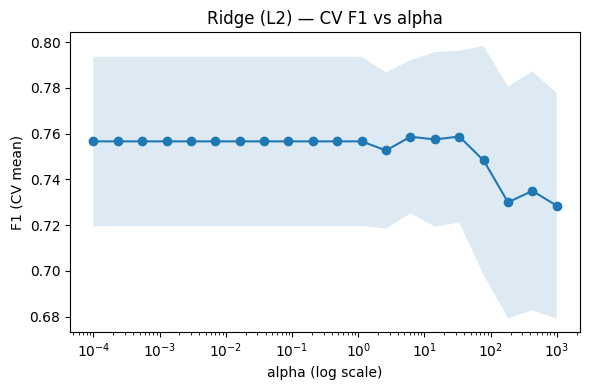

Best alpha (CV): 33.598183
                                    Model  Accuracy  Precision    Recall  \
0  Linear Regression (thr=0.5) | CV=5 OOF  0.835017   0.826087  0.722222   
1   Ridge (L2, thr=0.5) | alpha=33.598183       NaN        NaN       NaN   

         F1  accuracy  precision    recall        f1  
0  0.770671       NaN        NaN       NaN       NaN  
1       NaN  0.837989   0.833333  0.724638  0.775194  


In [473]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, make_scorer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- scorer: F1 a soglia 0.5 su predizioni continue ---
def f1_at_05(y_true, y_pred_cont):
    y_pred = (y_pred_cont >= 0.5).astype(int)
    return f1_score(y_true, y_pred)

scorer_f1_thr = make_scorer(f1_at_05, greater_is_better=True)

# --- griglia di alpha (log-scale) ---
alphas = np.logspace(-4, 3, 20)

# --- CV per ogni alpha ---
cv_means, cv_stds = [], []
for a in alphas:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=scorer_f1_thr, n_jobs=-1)
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

# --- risultati CV in DataFrame ---
ridge_cv_results = pd.DataFrame({
    "alpha": alphas,
    "mean_f1_cv": cv_means,
    "std_f1_cv": cv_stds
}).sort_values("alpha").reset_index(drop=True)

print(ridge_cv_results)

# --- grafico F1 vs alpha ---
plt.figure(figsize=(6,4))
plt.semilogx(ridge_cv_results["alpha"], ridge_cv_results["mean_f1_cv"], marker="o")
plt.fill_between(
    ridge_cv_results["alpha"],
    ridge_cv_results["mean_f1_cv"] - ridge_cv_results["std_f1_cv"],
    ridge_cv_results["mean_f1_cv"] + ridge_cv_results["std_f1_cv"],
    alpha=0.15
)
plt.xlabel("alpha (log scale)")
plt.ylabel("F1 (CV mean)")
plt.title("Ridge (L2) — CV F1 vs alpha")
plt.tight_layout()
plt.show()

# --- best alpha secondo CV (massimo mean F1) ---
best_idx = ridge_cv_results["mean_f1_cv"].idxmax()
best_alpha = ridge_cv_results.loc[best_idx, "alpha"]
print(f"Best alpha (CV): {best_alpha:.6f}")

# --- fit finale su TRAIN e valutazione su HOLD-OUT ---
best_pipe = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
best_pipe.fit(X_train, y_train)

y_val_pred_cont = best_pipe.predict(X_val)
y_val_pred = (y_val_pred_cont >= 0.5).astype(int)

row_val = pd.DataFrame([{
    "Model": f"Ridge (L2, thr=0.5) | alpha={best_alpha:.6f}",
    "accuracy": accuracy_score(y_val, y_val_pred),
    "precision": precision_score(y_val, y_val_pred),
    "recall": recall_score(y_val, y_val_pred),
    "f1": f1_score(y_val, y_val_pred)
}])

# Assicura che df_results esista con i tipi giusti; altrimenti crealo
if "df_results" not in locals():
    df_results = pd.DataFrame({
        "Model": pd.Series(dtype="str"),
        "accuracy": pd.Series(dtype="float"),
        "precision": pd.Series(dtype="float"),
        "recall": pd.Series(dtype="float"),
        "f1": pd.Series(dtype="float")
    })

df_results = pd.concat([df_results, row_val], ignore_index=True)
print(df_results)


#### 4.1.3. Lasso Regression (L1 regularization)

In [468]:
lasso = Lasso(alpha=0.01)   # try smaller alpha for Lasso to converge
lasso.fit(X_train, y_train)
y_pred_lasso = (lasso.predict(X_val) >= 0.5).astype(int)

print("\nLasso Regression")
print("Accuracy :", accuracy_score(y_val, y_pred_lasso))
print("Precision:", precision_score(y_val, y_pred_lasso))
print("Recall   :", recall_score(y_val, y_pred_lasso))
print("F1       :", f1_score(y_val, y_pred_lasso))


Lasso Regression
Accuracy : 0.7988826815642458
Precision: 0.7619047619047619
Recall   : 0.6956521739130435
F1       : 0.7272727272727273


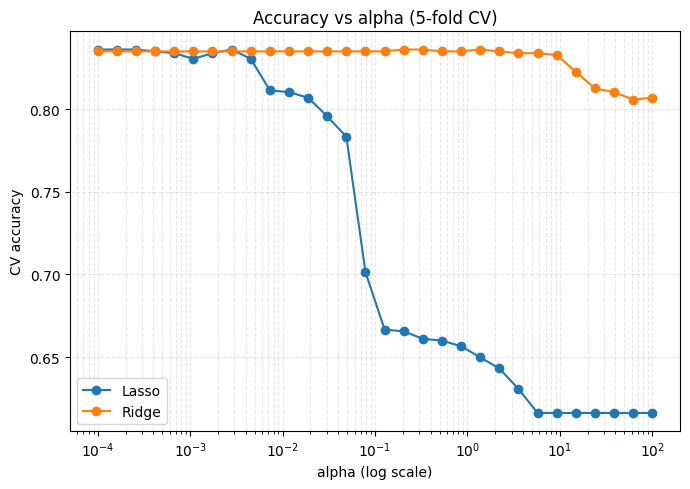

Best Ridge alpha: 1.3738 | Acc: 0.8361
Best Lasso alpha: 0.0001 | Acc: 0.8361
                feature  ridge_coef  lasso_coef
7              Title_Mr   -0.480464   -0.541856
21  Family group_Medium   -0.391463   -0.571039
22   Family group_Large   -0.388480   -0.715960
9           Title_Other   -0.359388   -0.481960
18         AgeBin_70-79   -0.321253   -0.353239
3              Sex_male   -0.286972   -0.503598
6            Title_Miss   -0.256816   -0.493040
19           AgeBin_80+    0.223512    0.455422
8             Title_Mrs   -0.219738   -0.453407
16         AgeBin_50-59   -0.218616   -0.190078
11             Pclass_3   -0.200027   -0.215210
26    Sex_Pclass_male_2   -0.187075   -0.235097
17         AgeBin_60-69   -0.180939   -0.166391
15         AgeBin_40-49   -0.176979   -0.155327
24  Sex_Pclass_female_3   -0.146903   -0.127046
13         AgeBin_20-29   -0.105803   -0.085130
23  Sex_Pclass_female_2    0.100576    0.010382
10             Pclass_2   -0.086499    0.000000
12        

<Figure size 800x600 with 0 Axes>

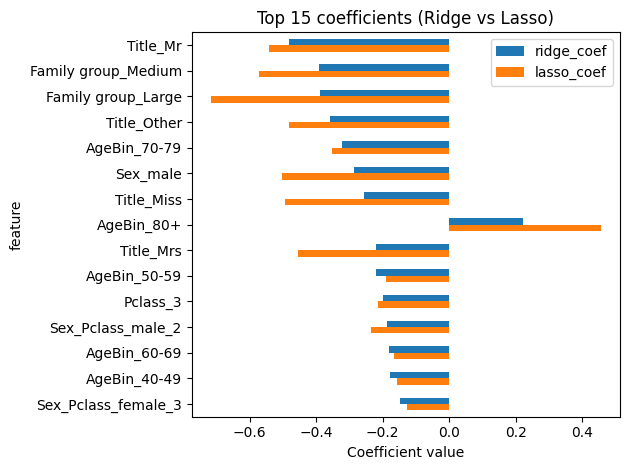

In [469]:
# helpers ------------------------------------------------------------
def _to_numpy(a):
    return a.values if hasattr(a, "values") else np.asarray(a)

def _get_feature_names(X):
    return list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(_to_numpy(X).shape[1])]

def cv_accuracy_vs_alpha(model_cls, alphas, X, y, n_splits=5, random_state=42):
    Xn, yn = _to_numpy(X), _to_numpy(y).ravel()
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows = []
    for a in alphas:
        fold_acc = []
        for tr_idx, va_idx in cv.split(Xn, yn):
            X_tr, X_va = Xn[tr_idx], Xn[va_idx]
            y_tr, y_va = yn[tr_idx], yn[va_idx]
            model = model_cls(alpha=a) if model_cls is not LinearRegression else model_cls()
            model.fit(X_tr, y_tr)
            y_hat = (model.predict(X_va) >= 0.5).astype(int)
            fold_acc.append(accuracy_score(y_va, y_hat))
        rows.append({"alpha": a, "accuracy": float(np.mean(fold_acc))})
    return pd.DataFrame(rows)

# main ---------------------------------------------------------------
X_all, y_all = X, y
alphas = np.logspace(-4, 2, 30)

ridge_df = cv_accuracy_vs_alpha(Ridge, alphas, X_all, y_all)
lasso_df = cv_accuracy_vs_alpha(Lasso, alphas, X_all, y_all)

results_df = pd.concat([
    ridge_df.assign(model="Ridge"),
    lasso_df.assign(model="Lasso")
], ignore_index=True)

plt.figure(figsize=(7,5))
for m, df in results_df.groupby("model"):
    df = df.sort_values("alpha")
    plt.semilogx(df["alpha"], df["accuracy"], marker="o", label=m)
plt.xlabel("alpha (log scale)")
plt.ylabel("CV accuracy")
plt.title("Accuracy vs alpha (5-fold CV)")
plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

best_ridge_alpha = ridge_df.loc[ridge_df["accuracy"].idxmax(), "alpha"]
best_lasso_alpha = lasso_df.loc[lasso_df["accuracy"].idxmax(), "alpha"]
print(f"Best Ridge alpha: {best_ridge_alpha:.5g} | Acc: {ridge_df["accuracy"].max():.4f}")
print(f"Best Lasso alpha: {best_lasso_alpha:.5g} | Acc: {lasso_df["accuracy"].max():.4f}")

# fit finale su tutto il train con i migliori alpha
Xn, yn = _to_numpy(X_all), _to_numpy(y_all).ravel()
ridge_best = Ridge(alpha=best_ridge_alpha).fit(Xn, yn)
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=20000).fit(Xn, yn)

feat_names = _get_feature_names(X_all)
coef_df = pd.DataFrame({
    "feature": feat_names,
    "ridge_coef": ridge_best.coef_,
    "lasso_coef": lasso_best.coef_,
}).sort_values("ridge_coef", key=lambda s: s.abs(), ascending=False)

print(coef_df.head(20))

# barplot coefficienti principali
top_k = min(15, len(feat_names))
plot_df = coef_df.set_index("feature").iloc[:top_k]
plt.figure(figsize=(8,6))
plot_df[["ridge_coef","lasso_coef"]].plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_k} coefficients (Ridge vs Lasso)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()


### 4.2 Naive Bayes

In [470]:
# --- Ensure X is a DataFrame with column names ---
# (Se X è già un DataFrame, questa riga non cambia nulla)
X = pd.DataFrame(X, columns=X.columns if hasattr(X, "columns") else [f"x{i}" for i in range(np.asarray(X).shape[1])])
y = pd.Series(y, name="Survived")

# Continuous columns to binarize for BernoulliNB (use only those that exist)
cont_cols = [c for c in ["Age", "Fare", "SibSp", "Parch", "Family size"] if c in X.columns]
bin_cols  = [c for c in X.columns if c not in cont_cols]  # dummies (0/1) already

# Preprocess: 2 quantile bins -> {0,1} for continuous; passthrough for the rest
bern_pre = ColumnTransformer(
    transformers=[
        ("bin_cont", KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="quantile"), cont_cols),
        ("pass_bin", "passthrough", bin_cols),
    ],
    remainder="drop"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_eval(pipe, X, y, cv):
    metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
    for tr, va in cv.split(X, y):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        pipe.fit(X_tr, y_tr)
        y_hat = pipe.predict(X_va)
        metrics["accuracy"].append(accuracy_score(y_va, y_hat))
        metrics["precision"].append(precision_score(y_va, y_hat))
        metrics["recall"].append(recall_score(y_va, y_hat))
        metrics["f1"].append(f1_score(y_va, y_hat))
    return {m: float(np.mean(v)) for m, v in metrics.items()}

rows = []

# BernoulliNB: try two alphas
for a in [1.0, 0.01]:
    bern_pipe = Pipeline([
        ("prep", bern_pre),
        ("clf", BernoulliNB(alpha=a))
    ])
    s = cv_eval(bern_pipe, X, y, cv)
    rows.append({"Model": f"BernoulliNB (alpha={a})", **s})

# GaussianNB (no Laplace alpha)
gauss_pipe = Pipeline([("identity", "passthrough"), ("clf", GaussianNB())])
s = cv_eval(gauss_pipe, X, y, cv)
rows.append({"Model": "GaussianNB", **s})

nb_results = pd.DataFrame(rows)
print(nb_results)

# Se stai usando df_results globale, aggiungo
try:
    df_results = pd.concat([df_results, nb_results], ignore_index=True)
except NameError:
    df_results = nb_results.copy()

# --- Plot confronto (accuracy e f1) ---
plt.figure(figsize=(7,5))
x = np.arange(len(df_results))
plt.plot(df_results["Model"], df_results["accuracy"], marker="o", label="Accuracy")
plt.plot(df_results["Model"], df_results["f1"], marker="o", label="F1")
plt.xticks(rotation=15)
plt.ylabel("Score")
plt.title("Naive Bayes: CV performance")
plt.grid(True, alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# --- Fit finale del migliore BernoulliNB e log-odds per feature (con nomi) ---
bern_best_alpha = max(
    [r for r in rows if r["Model"].startswith("BernoulliNB")],
    key=lambda d: d["accuracy"]
)["Model"].split("alpha=")[1].rstrip(")")

bern_best = Pipeline([("prep", bern_pre), ("clf", BernoulliNB(alpha=float(bern_best_alpha)))])
bern_best.fit(X, y)

# Nomi feature in output del ColumnTransformer: con 2 bin e encode="ordinal" rimane 1 col/feature continua
bern_feature_names = cont_cols + bin_cols

# Log-odds: log P(x=1|y=1) - log P(x=1|y=0)
log_odds = bern_best.named_steps["clf"].feature_log_prob_[1] - bern_best.named_steps["clf"].feature_log_prob_[0]
coef_bern = pd.Series(log_odds, index=bern_feature_names).sort_values(key=lambda s: s.abs(), ascending=False)

print("\nTop BernoulliNB log-odds features:")
print(coef_bern.head(20))

# (opzionale) bar chart delle top-k
top_k = min(15, len(coef_bern))
plt.figure(figsize=(8,6))
coef_bern.iloc[:top_k][::-1].plot(kind="barh")
plt.title(f"Top {top_k} BernoulliNB log-odds")
plt.xlabel("log P(x=1|y=1) - log P(x=1|y=0)")
plt.tight_layout()
plt.show()


NameError: name 'ColumnTransformer' is not defined

## 5 Model Evaluation

In [ ]:
df_results.sort_values(by="f1", ascending=False)

In [ ]:
df_results.set_index("Model", inplace=True)
ax = df_results.plot(kind="bar", figsize=(10, 6))

plt.title("Performance dei Modelli")
plt.xlabel("Modelli")
plt.ylabel("Punteggio")
plt.legend(title="Metriche")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()